In [2]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together



### Define functions

In [2]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
#     df=df[(df['GalpropMstar'] > 0) & (df['HalopropMhot'] > 0)]
#     df=df[df['GalpropMbulge'] >= 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df.loc[:,'GalpropLogMstar']=np.log10(df.loc[:,'GalpropMstar'])
    df.loc[:,'GalpropLogHalfRadius']=np.log10(df.loc[:, 'GalpropHalfRadius'])
    df.loc[:,'GalpropLogMvir']=np.log10(df.loc[:,'GalpropMvir'])
    df.loc[:,'HalopropLogMhot']=np.log10(df.loc[:,'HalopropMhot'])
    df.loc[:,'GalpropLogMbulge']=df.loc[:,'GalpropMbulge'].apply(lambda x: np.log10(x) if x>0 else 0)

    return df

In [3]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['sfr'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['sfr_log']=np.log10(df['sfr'])

    return df

In [4]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [5]:
# function to return the base 10 logarithm of non-zero values
def return_log_SFR(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return -2

In [6]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

### <font color='blue'> Define data frame

In [7]:
df=pd.read_hdf('./tng-sam.h5') # latest version, downloaded on Mar 29, 2022


In [8]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

In [9]:
# this df contains only central galaxies; features are from TNG-SAM
df

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot
0,20018.800569,350.895988,1.443460e+06,3.679530e+06,0.0,0.000000e+00,1.705140e+03,6.908500e+06,1.918680e+04,0.000000,8.945970e+08,0.252340,8.945970e+08,0.001531,1.423740e-06,1.380600e-07,0.612071,0.0,0.0,0.025384,2.099810e-07,1.979410e-07,6.009140e-07,1.288690e-07,177.934006,11.098500,11.098500,-99.0,12.273600,6.425340e-06,1.847320e-08,16.569099,554.130005,0.719250,-153.419998,11.507400,-43.490002,27.518700,0.0,0.0,0.000000e+00,0.004302,0.0,8.604240e+07,0.000000e+00,0.0,0.0,0.000019,1.150910e+08,0.000000,8.945970e+08,0.03410,15161.799638
1,40024.599002,574.640978,1.239300e+06,1.143740e+07,0.0,0.000000e+00,9.893530e+04,1.711920e+07,5.311550e+05,10444.399777,1.815770e+09,0.633187,1.815770e+09,0.001252,3.990530e-06,3.582890e-04,1.109940,0.0,0.0,0.032140,3.485530e-07,3.242180e-07,1.351500e-06,2.137210e-07,33.827702,12.596600,12.596600,-99.0,15.539900,5.455150e-05,2.259670e-06,16.276899,313.899994,0.460703,-11.270000,11.398200,-0.410000,25.676800,0.0,0.0,0.000000e+00,0.019309,0.0,3.854190e+08,0.000000e+00,0.0,0.0,0.000851,9.966590e+07,2611.099944,1.815770e+09,0.04884,216603.002627
2,50031.499995,120702.999993,5.135660e+07,4.998590e+07,0.0,1.220900e-09,2.745250e+05,1.371970e+08,1.461610e+06,160769.996000,4.880430e+09,0.322417,4.880430e+09,0.031506,1.380590e-04,3.465510e-03,1.129830,0.0,0.0,0.044686,7.226970e-05,6.617360e-05,6.443090e-05,4.429730e-05,22.934900,9.528780,9.528780,-99.0,30.950001,6.013470e-04,7.569950e-06,16.380501,262.940002,0.550576,73.919998,11.119700,3.790000,24.664200,0.0,0.0,1.220900e-09,0.048019,0.0,9.622790e+08,4.024750e+07,0.0,0.0,0.002521,1.409960e+07,40192.499000,4.880430e+09,0.07510,36659.101170
3,40051.898395,381.580008,3.270910e+06,1.616670e+07,0.0,0.000000e+00,2.401990e+03,2.625970e+07,5.375590e+03,1542.950031,1.860050e+09,0.368127,1.860050e+09,0.000802,1.775820e-07,5.426130e-08,0.905608,0.0,0.0,0.032399,2.283380e-07,2.113540e-07,3.027170e-07,1.400330e-07,242.033997,9.213750,9.213750,-99.0,15.665200,5.815860e-06,2.387450e-09,16.248199,276.200012,0.582477,346.070007,11.550300,160.419998,19.896200,0.0,0.0,0.000000e+00,0.005434,0.0,1.089770e+08,0.000000e+00,0.0,0.0,0.000003,1.573440e+08,385.737991,1.860050e+09,0.03953,3445.260063
4,10012.299754,66.861098,6.551900e+05,8.209490e+06,0.0,0.000000e+00,0.000000e+00,1.197780e+07,1.164560e+04,0.000000,1.615000e+09,0.000000,1.615000e+09,0.000162,9.262110e-08,0.000000e+00,0.967984,0.0,0.0,0.030909,4.000970e-08,3.698650e-08,6.046420e-08,2.453510e-08,8.818630,113.702003,113.702003,-99.0,14.944600,6.864240e-06,1.009730e-08,16.855400,492.170013,0.500886,366.100006,11.526400,122.190002,28.457001,0.0,0.0,0.000000e+00,0.005748,0.0,1.147010e+08,0.000000e+00,0.0,0.0,0.000008,1.273490e+08,0.000000,1.615000e+09,0.04429,9826.449968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924830,20007.200874,58.854901,2.741280e+05,1.512690e+06,0.0,0.000000e+00,4.672700e+01,2.412170e+06,1.155000e+03,0.000000,8.857400e+08,0.237968,8.857400e+08,0.000259,1.035180e-07,1.623750e-10,0.357797,0.

In [10]:
# 1) replace 0s with NaN 2) .isnull() gives boolean (whether NaN is true or false)
# 3) .sum() sums the true instances (that is, all 0s in a column)
# 4) dividing by shape[0] divides by the number of total entries (1,346,899) 5) *100 to convert to percentages
100*df.replace(0, np.nan).isnull().sum()/df.shape[0] 

GalpropMBH                            0.000000
GalpropMH2                           24.464344
GalpropMHI                           21.113536
GalpropMHII                          12.992585
GalpropMaccdot                       99.981068
GalpropMaccdot_radio                 55.505647
GalpropMbulge                        34.424927
GalpropMcold                         12.993328
GalpropMstar                         12.942619
GalpropMstar_merge                   63.587693
GalpropMstrip                         0.000000
GalpropMu_merger                     35.659318
GalpropMvir                           0.000000
GalpropOutflowRate_Mass              22.909736
GalpropOutflowRate_Metal             23.707791
GalpropRbulge                        34.424927
GalpropRdisk                          0.000000
GalpropRedshift                     100.000000
GalpropRfric                        100.000000
GalpropRhalo                          0.000000
GalpropSfr                           22.909736
GalpropSfrave

In [11]:
# calculate the percentage of 0s in each column in order to 1) remove columns of all 0s;
# 2) decide what strategy to use for columns with mostly 0s
df_percentage=pd.DataFrame(100*df.replace(0, np.nan).isnull().sum()/df.shape[0] )

In [12]:
df_percentage

,0
GalpropMBH,0.000000
GalpropMH2,24.464344
GalpropMHI,21.113536
GalpropMHII,12.992585
GalpropMaccdot,99.981068
GalpropMaccdot_radio,55.505647
GalpropMbulge,34.424927
GalpropMcold,12.993328
GalpropMstar,12.942619
GalpropMstar_merge,63.587693


In [13]:
# df_percentage.to_csv('percentage of 0s.csv', index=True)

### <font color='blue'> Filter the dataset

In [14]:
# remove all galaxies with stellar mass < 1e8
df_mass_filtered = df.loc[df.GalpropMstar>1e8,:]

In [15]:
df_mass_filtered.shape # 35,390 central galaxies with stellar mass >1e8

(35390, 53)

In [16]:
df_mass_filtered

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot
53,1.301360e+05,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,4.502510e+09,0.288967,4.502510e+09,0.031659,0.000827,0.503721,1.03908,0.0,0.0,0.043502,0.000402,0.000375,0.000458,0.000247,22.108601,4.65438,4.654380,-99.0,21.033600,0.000008,0.004245,16.066799,558.080017,1.714200,-65.139999,12.544000,78.750000,59.129101,0.0,0.0,3.504660e-09,0.341844,0.0,6.824580e+09,3.162250e+07,0.0,0.0,0.114885,9.503960e+09,1.339210e+06,4.502510e+09,0.03378,1.048970e+08
59,5.412750e+05,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,1.285310e+11,0.231417,1.285310e+11,2.233340,0.414400,1.340100,1.44021,0.0,0.0,0.132950,0.101277,0.097127,0.146846,0.062210,62.561501,9.17507,113.702003,-99.0,84.190002,0.206532,0.485612,16.284800,364.420013,0.534603,166.160004,12.510000,68.620003,21.878799,0.0,0.0,4.201900e-08,1.571940,0.0,3.167380e+10,1.660060e+09,0.0,0.0,4.052160,8.516240e+05,1.781820e+07,1.285310e+11,0.03407,1.572950e+05
82,5.801040e+05,4.618540e+07,3.059520e+08,2.233320e+08,0.0,4.726200e-08,2.406350e+08,7.769080e+08,1.583780e+09,1.306340e+07,1.171930e+11,0.246886,1.171930e+11,1.601270,0.205984,1.801320,1.82321,0.0,0.0,0.128920,0.028763,0.026769,0.039126,0.017644,52.016201,12.53960,113.702003,-99.0,62.334499,0.099900,0.308089,17.358299,591.049988,0.686448,73.830002,11.700600,20.840000,23.447201,0.0,0.0,4.726200e-08,1.482840,0.0,2.979890e+10,1.540290e+09,0.0,0.0,3.075050,5.588210e+05,3.570910e+06,1.171930e+11,0.01407,6.596390e+04
98,1.366780e+06,6.824820e+07,5.498750e+08,3.847350e+08,0.0,1.404620e-07,3.234520e+08,1.352870e+09,1.241640e+09,5.510730e+07,1.705850e+11,0.202695,1.705850e+11,1.620810,0.192479,2.040110,2.30283,0.0,0.0,0.146106,0.042378,0.039515,0.043836,0.025998,53.934601,5.72324,113.702003,-99.0,70.643898,0.160787,0.204719,17.868500,183.699997,0.809891,-86.550003,12.407200,-43.040001,17.701000,0.0,0.0,1.404620e-07,1.290780,0.0,2.596220e+10,1.404660e+09,0.0,0.0,2.342900,1.107320e+06,1.431260e+07,1.705850e+11,0.02229,1.250460e+05
104,1.450610e+06,2.448120e+07,1.699390e+08,1.440650e+08,0.0,9.336400e-08,4.903280e+08,4.571360e+08,1.432650e+09,2.915260e+07,8.294760e+10,0.270533,8.294760e+10,1.186200,0.158633,1.414440,1.62481,0.0,0.0,0.114892,0.015081,0.013968,0.015898,0.009249,53.722198,3.92740,3.927400,-99.0,55.551498,0.061155,0.310911,18.018999,333.529999,1.296350,90.730003,12.578600,13.250000,42.640499,0.0,0.0,9.336400e-08,1.146570,0.0,2.303570e+10,1.166440e+09,0.0,0.0,2.762820,1.935800e+05,7.892150e+06,8.294760e+10,0.01128,2.566430e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,1.102630e+05,7.387440e+06,2.422220e+08,2.593020e+08,0.0,1.361980e-08,7.870290e+06,6.859500e+08,1.312080e+08,1.573820e+06,5.192210e+10,0.108908,5.192210e+10,0.558228,0.023214,0.861413,2.64082,0.0,0.0,0.098281,0.004443,0.004175,0.004072,0.002726,37.689499,12.31770,12.746900,-99.0,47.520199,0.028542,0.007200,105.570000,77.930000,98.05229

In [17]:
df_percentage_mass_filtered=pd.DataFrame(100*df_mass_filtered.replace(0, np.nan).isnull().sum()/df_mass_filtered.shape[0] )

In [18]:
df_percentage_mass_filtered

,0
GalpropMBH,0.000000
GalpropMH2,0.915513
GalpropMHI,0.652727
GalpropMHII,0.175191
GalpropMaccdot,99.282283
GalpropMaccdot_radio,0.031082
GalpropMbulge,0.014128
GalpropMcold,0.172365
GalpropMstar,0.000000
GalpropMstar_merge,0.016954


In [19]:
# df_percentage_mass_filtered.to_csv('mass filtered percentage of 0s.csv', index=True)

In [20]:
# df_mass_filtered['GalpropMaccdot'].value_counts() #accretion rate onto black hole; 35,135 (out of 35,390) entries are 0 

In [21]:
# df_mass_filtered['GalpropRedshift'].value_counts() #redshift is zero bec we're using only z=0 snapshot for current analysis

In [22]:
# df_mass_filtered['GalpropRfric'].value_counts() #accretion rate onto black hole, 0 everywhere

In [23]:
# df_mass_filtered['GalpropMstar'].value_counts() # stellar mass

In [24]:
np.log10(df_mass_filtered['GalpropMstar'].max()) # stellar mass

11.960913422974704

In [25]:
np.log10(df_mass_filtered['GalpropMvir'].max()) #total DM halo mass

14.686747956155516

### <font color='blue'> Add half_radius by applying half_mass_radius function to each row

In [26]:
# import matplotlib.pyplot as plt
# import galsim #install with conda install -c conda_forge galsim

def half_mass_radius(GalpropMstar,GalpropMbulge,GalpropRdisk,GalpropRbulge,tol=1.e-6,figure=False):
    '''calculate half mass radius for disk(n=1)+bulge(n=4) galaxy
    using bisection'''
    
    Md=GalpropMstar-GalpropMbulge # disk mass=stellar mass - bulge mass
    Rd=GalpropRdisk # disk radius
    Mb=GalpropMbulge # bulge mass
    Rb=GalpropRbulge # bulge radius
    
    disk_fraction=Md/(Md+Mb)
    bulge_fraction=Mb/(Md+Mb)
    if bulge_fraction==0:
        disk=galsim.Sersic(scale_radius=Rd,n=1)  
        return disk.half_light_radius     
    if disk_fraction==0:
        return Rb
    disk=galsim.Sersic(scale_radius=Rd,n=1)
    bulge=galsim.Sersic(half_light_radius=Rb,n=4)
    #starting points for bisection
    a=bulge.half_light_radius
    b=disk.half_light_radius
    if b < a:
        a=disk.half_light_radius
        b=bulge.half_light_radius

    #bisection
    Ma=disk_fraction*disk.calculateIntegratedFlux(a)+bulge_fraction*bulge.calculateIntegratedFlux(a)
    Mb=disk_fraction*disk.calculateIntegratedFlux(b)+bulge_fraction*bulge.calculateIntegratedFlux(b)
    if np.sign(Ma-0.5)==np.sign(Mb-0.5):
        raise Exception("a and b do not bound a root")
    while(b-a > tol):
        m=0.5*(a+b)
        f=(disk_fraction*disk.calculateIntegratedFlux(m)+
            bulge_fraction*bulge.calculateIntegratedFlux(m))-0.5
        if np.sign(f)==1:
            b=m
        else:
            a=m
    half_radius=0.5*(a+b)
    if figure:
        half=np.array([0.45,0.55]) #used for half marks
        R=np.arange(0,3*b,0.02)
        N=len(R)
        yd=np.zeros(N)
        yb=np.zeros(N)
        for i in range(N):
            yd[i]=disk_fraction*disk.calculateIntegratedFlux(R[i])
            yb[i]=bulge_fraction*bulge.calculateIntegratedFlux(R[i])
        plt.plot(R,yd,color='b',label='disk')
        plt.plot(R,yb,color='r',label='bulge')
        plt.plot(R,yd+yb,color='k',label='total')
        plt.plot([bulge.half_light_radius,bulge.half_light_radius],bulge_fraction*half,color='g')
        plt.plot([disk.half_light_radius,disk.half_light_radius],disk_fraction*half,color='g')
        plt.plot([half_radius,half_radius],half,color='g')
        plt.xlim([0,3*b])
        plt.ylim([0,1.0])
        plt.legend()
        plt.show()
    return half_radius

# if __name__=='__main__':
#     print(half_mass_radius(1.e10,3.5,0.e9,0.0,figure=True))

In [27]:
df_mass_filtered.iloc[101,:]

GalpropMBH                          1.202400e+05
GalpropMH2                          0.000000e+00
GalpropMHI                          0.000000e+00
GalpropMHII                         2.342960e+06
GalpropMaccdot                      0.000000e+00
GalpropMaccdot_radio                1.361390e-08
GalpropMbulge                       1.439710e+09
GalpropMcold                        2.550690e+07
GalpropMstar                        1.449540e+09
GalpropMstar_merge                  2.347960e+06
GalpropMstrip                       6.778860e+10
GalpropMu_merger                    0.000000e+00
GalpropMvir                         6.778860e+10
GalpropOutflowRate_Mass             3.248370e-01
GalpropOutflowRate_Metal            8.121380e-02
GalpropRbulge                       3.956790e-01
GalpropRdisk                        2.208780e+00
GalpropRedshift                     0.000000e+00
GalpropRfric                        0.000000e+00
GalpropRhalo                        1.074170e-01
GalpropSfr          

In [28]:
#for i,row in df_central.iterrows():
df_mass_filtered.loc[:,'GalpropHalfRadius'] = df_mass_filtered.apply(lambda x: half_mass_radius(GalpropMstar=x['GalpropMstar'],
                                                                                          GalpropMbulge=x['GalpropMbulge'],
                                                                                          GalpropRdisk=x['GalpropRdisk'],
                                                                                          GalpropRbulge=x['GalpropRbulge'],tol=1.e-6,figure=False), axis=1)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [29]:
df_mass_filtered['GalpropHalfRadius']

53         0.829693
59         2.332662
82         2.922134
98         3.491710
104        2.360156
             ...   
1918905    4.229993
1918910    5.548772
1918945    1.729907
1918947    2.406906
1918957    2.117134
Name: GalpropHalfRadius, Length: 35390, dtype: float64

In [30]:
# solution of the same problem using a for loop over the df rows
lst = []
for i,row in df_mass_filtered.iterrows():
    result_iter = half_mass_radius(GalpropMstar=row['GalpropMstar'],
                                   GalpropMbulge=row['GalpropMbulge'],
                                   GalpropRdisk=row['GalpropRdisk'],
                                   GalpropRbulge=row['GalpropRbulge'],tol=1.e-6,figure=False)

    lst.append(result_iter)
    if i>100:
        break
               

In [31]:
lst

[0.8296928630448805,
 2.3326619620962354,
 2.922134029718011,
 3.4917102387445444,
 2.3601561747952067]

### <font color='blue'> Logarithmic scale of stellar mass, SFR, Mhalo

In [32]:
df_mass_filtered.shape

(35390, 54)

In [33]:
df_log_mass_filtered=log_mass_size(df_mass_filtered)

In [34]:
df_log_mass_filtered.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot,GalpropHalfRadius,GalpropLogMstar,GalpropLogHalfRadius,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge
53,130136.002554,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,4.502510e+09,0.288967,4.502510e+09,0.031659,0.000827,0.503721,1.03908,0.0,0.0,0.043502,0.000402,0.000375,0.000458,0.000247,22.108601,4.65438,4.654380,-99.0,21.033600,0.000008,0.004245,16.066799,558.080017,1.714200,-65.139999,12.544,78.750000,59.129101,0.0,0.0,3.504660e-09,0.341844,0.0,6.824580e+09,3.162250e+07,0.0,0.0,0.114885,9.503960e+09,1.339210e+06,4.502510e+09,0.03378,1.048970e+08,0.829693,8.021516,-0.081083,9.653455,9.977905,7.860965
59,541275.017895,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,1.285310e+11,0.231417,1.285310e+11,2.233340,0.414400,1.340100,1.44021,0.0,0.0,0.132950,0.101277,0.097127,0.146846,0.062210,62.561501,9.17507,113.702003,-99.0,84.190002,0.206532,0.485612,16.284800,364.420013,0.534603,166.160004,12.510,68.620003,21.878799,0.0,0.0,4.201900e-08,1.571940,0.0,3.167380e+10,1.660060e+09,0.0,0.0,4.052160,8.516240e+05,1.781820e+07,1.285310e+11,0.03407,1.572950e+05,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093


In [35]:
df_log_mass_filtered.shape

(35390, 59)

In [36]:
df_log_mass_filtered['GalpropLogMbulge'].max()

11.926815581581586

In [37]:
df_log_mass_filtered['GalpropLogMbulge'].min()

0.0

In [38]:
df_log_mass_filtered['GalpropLogMvir'].min()

9.031287248029146

In [39]:
df_log_mass_filtered['GalpropLogMvir'].max()

14.686747956155516

In [40]:
df_log_mass_filtered['GalpropLogMstar'].max()

11.960913422974704

In [41]:
df_log_mass_filtered['GalpropLogHalfRadius'].max()

1.8067345375394124

In [42]:
df_log_mass_filtered['GalpropLogHalfRadius'].min()

-3.502156902134032

In [43]:
df_log_mass_filtered['GalpropHalfRadius'].max()

64.08177570547352

In [44]:
df_log_mass_filtered['GalpropHalfRadius'].min()

0.000314661129937268

In [45]:
df_log_mass_filtered.head(1)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot,GalpropHalfRadius,GalpropLogMstar,GalpropLogHalfRadius,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge
53,130136.002554,0.0,2.710510e-11,228346.005315,0.0,3.504660e-09,7.260470e+07,308221.991872,1.050790e+08,1.404410e+06,4.502510e+09,0.288967,4.502510e+09,0.031659,0.000827,0.503721,1.03908,0.0,0.0,0.043502,0.000402,0.000375,0.000458,0.000247,22.108601,4.65438,4.65438,-99.0,21.0336,0.000008,0.004245,16.066799,558.080017,1.7142,-65.139999,12.544,78.75,59.129101,0.0,0.0,3.504660e-09,0.341844,0.0,6.824580e+09,3.162250e+07,0.0,0.0,0.114885,9.503960e+09,1.339210e+06,4.502510e+09,0.03378,1.048970e+08,0.829693,8.021516,-0.081083,9.653455,9.977905,7.860965


In [47]:
def log_sfr(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR

    '''
    df.loc[:,'GalpropLogSfr']=df.loc[:,'GalpropSfr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave100myr']=df.loc[:,'GalpropSfrave100myr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave1gyr']=df.loc[:,'GalpropSfrave1gyr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave20myr']=df.loc[:,'GalpropSfrave20myr'].apply(lambda x: np.log10(x) if x>0 else 0)

    return df

In [48]:
# add a column with the logarithmic value of SFR, setting any SFR=0 to a fixed value of -2
df_log_mass_filtered=log_sfr(df_log_mass_filtered)

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [49]:
df_log_mass_filtered.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot,GalpropHalfRadius,GalpropLogMstar,GalpropLogHalfRadius,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr
53,130136.002554,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,4.502510e+09,0.288967,4.502510e+09,0.031659,0.000827,0.503721,1.03908,0.0,0.0,0.043502,0.000402,0.000375,0.000458,0.000247,22.108601,4.65438,4.654380,-99.0,21.033600,0.000008,0.004245,16.066799,558.080017,1.714200,-65.139999,12.544,78.750000,59.129101,0.0,0.0,3.504660e-09,0.341844,0.0,6.824580e+09,3.162250e+07,0.0,0.0,0.114885,9.503960e+09,1.339210e+06,4.502510e+09,0.03378,1.048970e+08,0.829693,8.021516,-0.081083,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164
59,541275.017895,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,1.285310e+11,0.231417,1.285310e+11,2.233340,0.414400,1.340100,1.44021,0.0,0.0,0.132950,0.101277,0.097127,0.146846,0.062210,62.561501,9.17507,113.702003,-99.0,84.190002,0.206532,0.485612,16.284800,364.420013,0.534603,166.160004,12.510,68.620003,21.878799,0.0,0.0,4.201900e-08,1.571940,0.0,3.167380e+10,1.660060e+09,0.0,0.0,4.052160,8.516240e+05,1.781820e+07,1.285310e+11,0.03407,1.572950e+05,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143


In [50]:
df_log_mass_filtered['GalpropSfr'].max()

123.108

In [51]:
df_log_mass_filtered['GalpropSfr'].min()

0.0

In [52]:
df_log_mass_filtered['GalpropSfrave100myr'].max()

89.8242

In [53]:
df_log_mass_filtered['GalpropSfrave1gyr'].max()

22.6472

In [54]:
df_log_mass_filtered['GalpropSfrave20myr'].max()

80.0798

In [55]:
df_log_mass_filtered['GalpropMBH'].max()

56504501342.77344

In [56]:
df_log_mass_filtered['GalpropMBH'].min()

10005.699550674763

In [57]:
df_log_mass_filtered['GalpropMHI'].max()

38528598785.40039

In [58]:
df_log_mass_filtered['GalpropMHI'].min()

0.0

### Gas fraction

In [60]:
df_log_mass_filtered.loc[:,'Galprop_neutral_H_mass']=(df_log_mass_filtered.loc[:,'GalpropMHI']+df_log_mass_filtered.loc[:,'GalpropMH2'])
df_log_mass_filtered.loc[:,'Galprop_baryon_mass']=df_log_mass_filtered.loc[:,'Galprop_neutral_H_mass']+df_log_mass_filtered.loc[:,'GalpropMstar']
df_log_mass_filtered.loc[:,'Galprop_gas_fraction']=df_log_mass_filtered.loc[:,'Galprop_neutral_H_mass']/df_log_mass_filtered.loc[:,'Galprop_baryon_mass']

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [61]:
df_log_mass_filtered.shape

(35390, 66)

In [62]:
np.count_nonzero(df_log_mass_filtered['GalpropHalfRadius']) # this means that there are no size zero entries in TNG-SAM

35390

In [63]:
df_log_mass_filtered.GalpropHalfRadius.max()

64.08177570547352

In [64]:
df_log_mass_filtered.GalpropHalfRadius.min()

0.000314661129937268

In [65]:
df_log_mass_filtered.Galprop_gas_fraction.max()

0.988460838898951

In [66]:
df_log_mass_filtered.Galprop_gas_fraction.min()

0.0

#### Save data set and use it in the next version of the notebook

In [67]:
df_log_mass_filtered.shape

(35390, 66)

In [68]:
# df_log_mass_filtered.to_csv('df_log_mass_filtered_v5.csv', index=False)

In [5]:
df_log_mass_filtered = pd.read_csv ('df_log_mass_filtered_v5.csv') # df here read from the csv in previous line

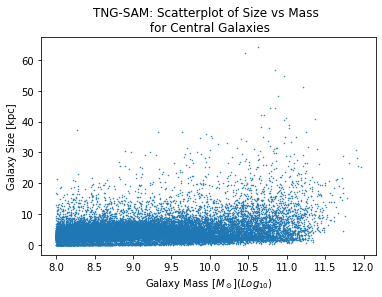

In [6]:
plt.plot(df_log_mass_filtered['GalpropLogMstar'], df_log_mass_filtered['GalpropHalfRadius'], '.', markersize=1)
plt.title('TNG-SAM: Scatterplot of Size vs Mass \n for Central Galaxies')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
plt.ylabel('Galaxy Size [kpc]')
# plt.savefig("TNG-SAM_centrals_scatterplot_v3.jpeg", dpi=500)

plt.show()

## Correlations for all masses

In [71]:
df_log_mass_filtered.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropMvir,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRedshift,GalpropRfric,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropTsat,GalpropVdisk,GalpropZcold,GalpropZstar,GalpropX,GalpropVx,GalpropY,GalpropVy,GalpropZ,GalpropVz,HalopropC_nfw,HalopropMaccdot_metal,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate_metal,HalopropMass_ejected,HalopropMcooldot,HalopropMdot_eject,HalopropMdot_eject_metal,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropSpin,HalopropZhot,GalpropHalfRadius,GalpropLogMstar,GalpropLogHalfRadius,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction
53,130136.002554,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,4.502510e+09,0.288967,4.502510e+09,0.031659,0.000827,0.503721,1.03908,0.0,0.0,0.043502,0.000402,0.000375,0.000458,0.000247,22.108601,4.65438,4.654380,-99.0,21.033600,0.000008,0.004245,16.066799,558.080017,1.714200,-65.139999,12.544,78.750000,59.129101,0.0,0.0,3.504660e-09,0.341844,0.0,6.824580e+09,3.162250e+07,0.0,0.0,0.114885,9.503960e+09,1.339210e+06,4.502510e+09,0.03378,1.048970e+08,0.829693,8.021516,-0.081083,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19
59,541275.017895,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,1.285310e+11,0.231417,1.285310e+11,2.233340,0.414400,1.340100,1.44021,0.0,0.0,0.132950,0.101277,0.097127,0.146846,0.062210,62.561501,9.17507,113.702003,-99.0,84.190002,0.206532,0.485612,16.284800,364.420013,0.534603,166.160004,12.510,68.620003,21.878799,0.0,0.0,4.201900e-08,1.571940,0.0,3.167380e+10,1.660060e+09,0.0,0.0,4.052160,8.516240e+05,1.781820e+07,1.285310e+11,0.03407,1.572950e+05,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01


In [72]:
df_log_mass_filtered['GalpropTsat'].value_counts() # same value for all entries, so remove it from df

-99.0    35390
Name: GalpropTsat, dtype: int64

In [75]:
df_pairplot=df_log_mass_filtered.drop(columns =['GalpropRedshift', 
                                               'GalpropRfric', 'HalopropMaccdot_metal', 'HalopropMaccdot_pristine',
                                               'HalopropMaccdot_reaccreate_metal', 'HalopropMcooldot',
                                               'HalopropMdot_eject', 'HalopropMdot_eject_metal',
                                               'GalpropX', 'GalpropVx','GalpropY', 'GalpropVy',
                                               'GalpropZ', 'GalpropVz', 'GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'GalpropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropRbulge', 'GalpropRdisk', 'GalpropMvir'])

In [76]:
df_pairplot.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMbulge',
       'GalpropMcold', 'GalpropMstar', 'GalpropMstar_merge', 'GalpropMstrip',
       'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropRhalo', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropSigmaBulge', 'GalpropTmerger', 'GalpropTmerger_major',
       'GalpropVdisk', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMass_ejected', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropSpin', 'HalopropZhot',
       'GalpropHalfRadius'],
      dtype='object')>

In [78]:
df_pairplot=df_pairplot.loc[:, ['GalpropMu_merger','GalpropMaccdot',  'GalpropTmerger', 'GalpropOutflowRate_Mass', 'GalpropTmerger_major',
                                'GalpropOutflowRate_Metal',
                                'GalpropSigmaBulge', 'GalpropMbulge',
                                'GalpropSfr','GalpropSfrave100myr',  'GalpropSfrave20myr', 
                                'GalpropMBH','GalpropMstar_merge',  'GalpropMH2', 
                                'GalpropZstar', 'GalpropSfrave1gyr','GalpropMaccdot_radio', 'GalpropMstar', 'GalpropVdisk',
                                'GalpropMstrip', 'GalpropRhalo','GalpropZcold', 'GalpropMHI',
                                'GalpropMcold', 'GalpropMHII',  
                                'HalopropC_nfw', 'HalopropMstar_diffuse', 'HalopropMetal_ejected',
                                'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
                                'HalopropMhot', 'HalopropZhot', 'HalopropMvir', 'HalopropSpin',
                                'GalpropHalfRadius' ]]

In [79]:
df_pairplot

,GalpropMu_merger,GalpropMaccdot,GalpropTmerger,GalpropOutflowRate_Mass,GalpropTmerger_major,GalpropOutflowRate_Metal,GalpropSigmaBulge,GalpropMbulge,GalpropSfr,GalpropSfrave100myr,GalpropSfrave20myr,GalpropMBH,GalpropMstar_merge,GalpropMH2,GalpropZstar,GalpropSfrave1gyr,GalpropMaccdot_radio,GalpropMstar,GalpropVdisk,GalpropMstrip,GalpropRhalo,GalpropZcold,GalpropMHI,GalpropMcold,GalpropMHII,HalopropC_nfw,HalopropMstar_diffuse,HalopropMetal_ejected,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMass_ejected,HalopropMhot,HalopropZhot,HalopropMvir,HalopropSpin,GalpropHalfRadius
53,0.288967,0.0,4.65438,0.031659,4.654380,0.000827,22.108601,7.260470e+07,0.000402,0.000375,0.000247,1.301360e+05,1.404410e+06,0.000000e+00,0.004245,0.000458,3.504660e-09,1.050790e+08,21.033600,4.502510e+09,0.043502,0.000008,2.710510e-11,3.082220e+05,2.283460e+05,59.129101,1.339210e+06,0.114885,3.504660e-09,0.341844,6.824580e+09,9.503960e+09,1.048970e+08,4.502510e+09,0.03378,0.829693
59,0.231417,0.0,9.17507,2.233340,113.702003,0.414400,62.561501,2.312560e+08,0.101277,0.097127,0.062210,5.412750e+05,4.105360e+07,1.455160e+08,0.485612,0.146846,4.201900e-08,2.136860e+09,84.190002,1.285310e+11,0.132950,0.206532,4.310100e+08,1.111490e+09,2.505300e+08,21.878799,1.781820e+07,4.052160,4.201900e-08,1.571940,3.167380e+10,8.516240e+05,1.572950e+05,1.285310e+11,0.03407,2.332662
82,0.246886,0.0,12.53960,1.601270,113.702003,0.205984,52.016201,2.406350e+08,0.028763,0.026769,0.017644,5.801040e+05,1.306340e+07,4.618540e+07,0.308089,0.039126,4.726200e-08,1.583780e+09,62.334499,1.171930e+11,0.128920,0.099900,3.059520e+08,7.769080e+08,2.233320e+08,23.447201,3.570910e+06,3.075050,4.726200e-08,1.482840,2.979890e+10,5.588210e+05,6.596390e+04,1.171930e+11,0.01407,2.922134
98,0.202695,0.0,5.72324,1.620810,113.702003,0.192479,53.934601,3.234520e+08,0.042378,0.039515,0.025998,1.366780e+06,5.510730e+07,6.824820e+07,0.204719,0.043836,1.404620e-07,1.241640e+09,70.643898,1.705850e+11,0.146106,0.160787,5.498750e+08,1.352870e+09,3.847350e+08,17.701000,1.431260e+07,2.342900,1.404620e-07,1.290780,2.596220e+10,1.107320e+06,1.250460e+05,1.705850e+11,0.02229,3.491710
104,0.270533,0.0,3.92740,1.186200,3.927400,0.158633,53.722198,4.903280e+08,0.015081,0.013968,0.009249,1.450610e+06,2.915260e+07,2.448120e+07,0.310911,0.015898,9.336400e-08,1.432650e+09,55.551498,8.294760e+10,0.114892,0.061155,1.699390e+08,4.571360e+08,1.440650e+08,42.640499,7.892150e+06,2.762820,9.336400e-08,1.146570,2.303570e+10,1.935800e+05,2.566430e+04,8.294760e+10,0.01128,2.360156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,0.108908,0.0,12.31770,0.558228,12.746900,0.023214,37.689499,7.870290e+06,0.004443,0.004175,0.002726,1.102630e+05,1.573820e+06,7.387440e+06,0.007200,0.004072,1.361980e-08,1.312080e+08,47.520199,5.192210e+10,0.098281,0.028542,2.422220e+08,6.859500e+08,2.593020e+08,24.981800,4.663290e+05,0.244565,1.361980e-08,0.375711,7.574120e+09,3.574300e+04,1.486320e+03,5.192210e+10,0.03800,4.229993
1918910,0.212072,0.0,12.49250,0.357314,113.702003,0.017189,34.250301,1.064620e+07,0.002984,0.002853,0.001833,1.803450e+05,1.432870e+06,4.975330e+06,0.005770,0.011160,2.598400e-08,1.234320e+08,48.307800,5.454680e+10,0.099910,0.036281,2.204080e+08,7.534590e+08,3.347660e+08,16.239500,3.735660e+05,0.210431,2.598400e-08,0.403118,8.094080e+09,4.573560e+08,1.070050e+07,5.454680e+10,0.04917,5.548772
1918945,0.215127,0.0,10.45080,2.181900,113.702003,0.060972,36.855202,2.044020e+07,0.051229,0.009683,0.025731,1.402810e+05,8.325890e+06,7.508750e+07,0.006112,0.003769,2.262000e-08,1.227350e+08,68.459999,5.175670e+10,0.098177,0.026656,4.174370e+08,9.392910e+08,2.042310e+08,20.015400,2.206560e+06,0.230961,2.262000e-08,0.409693,8.282770e+09,1.392480e+08,2.507350e+06,5.175670e+10,0.03464,1.729907
1918947,0.129173,0.0,11.57380,0.971531,113.702003,0.037233,41.272701,1.796060e+07,0.024660,0.021014,0.015065,1.603850e+05,1.797880e+

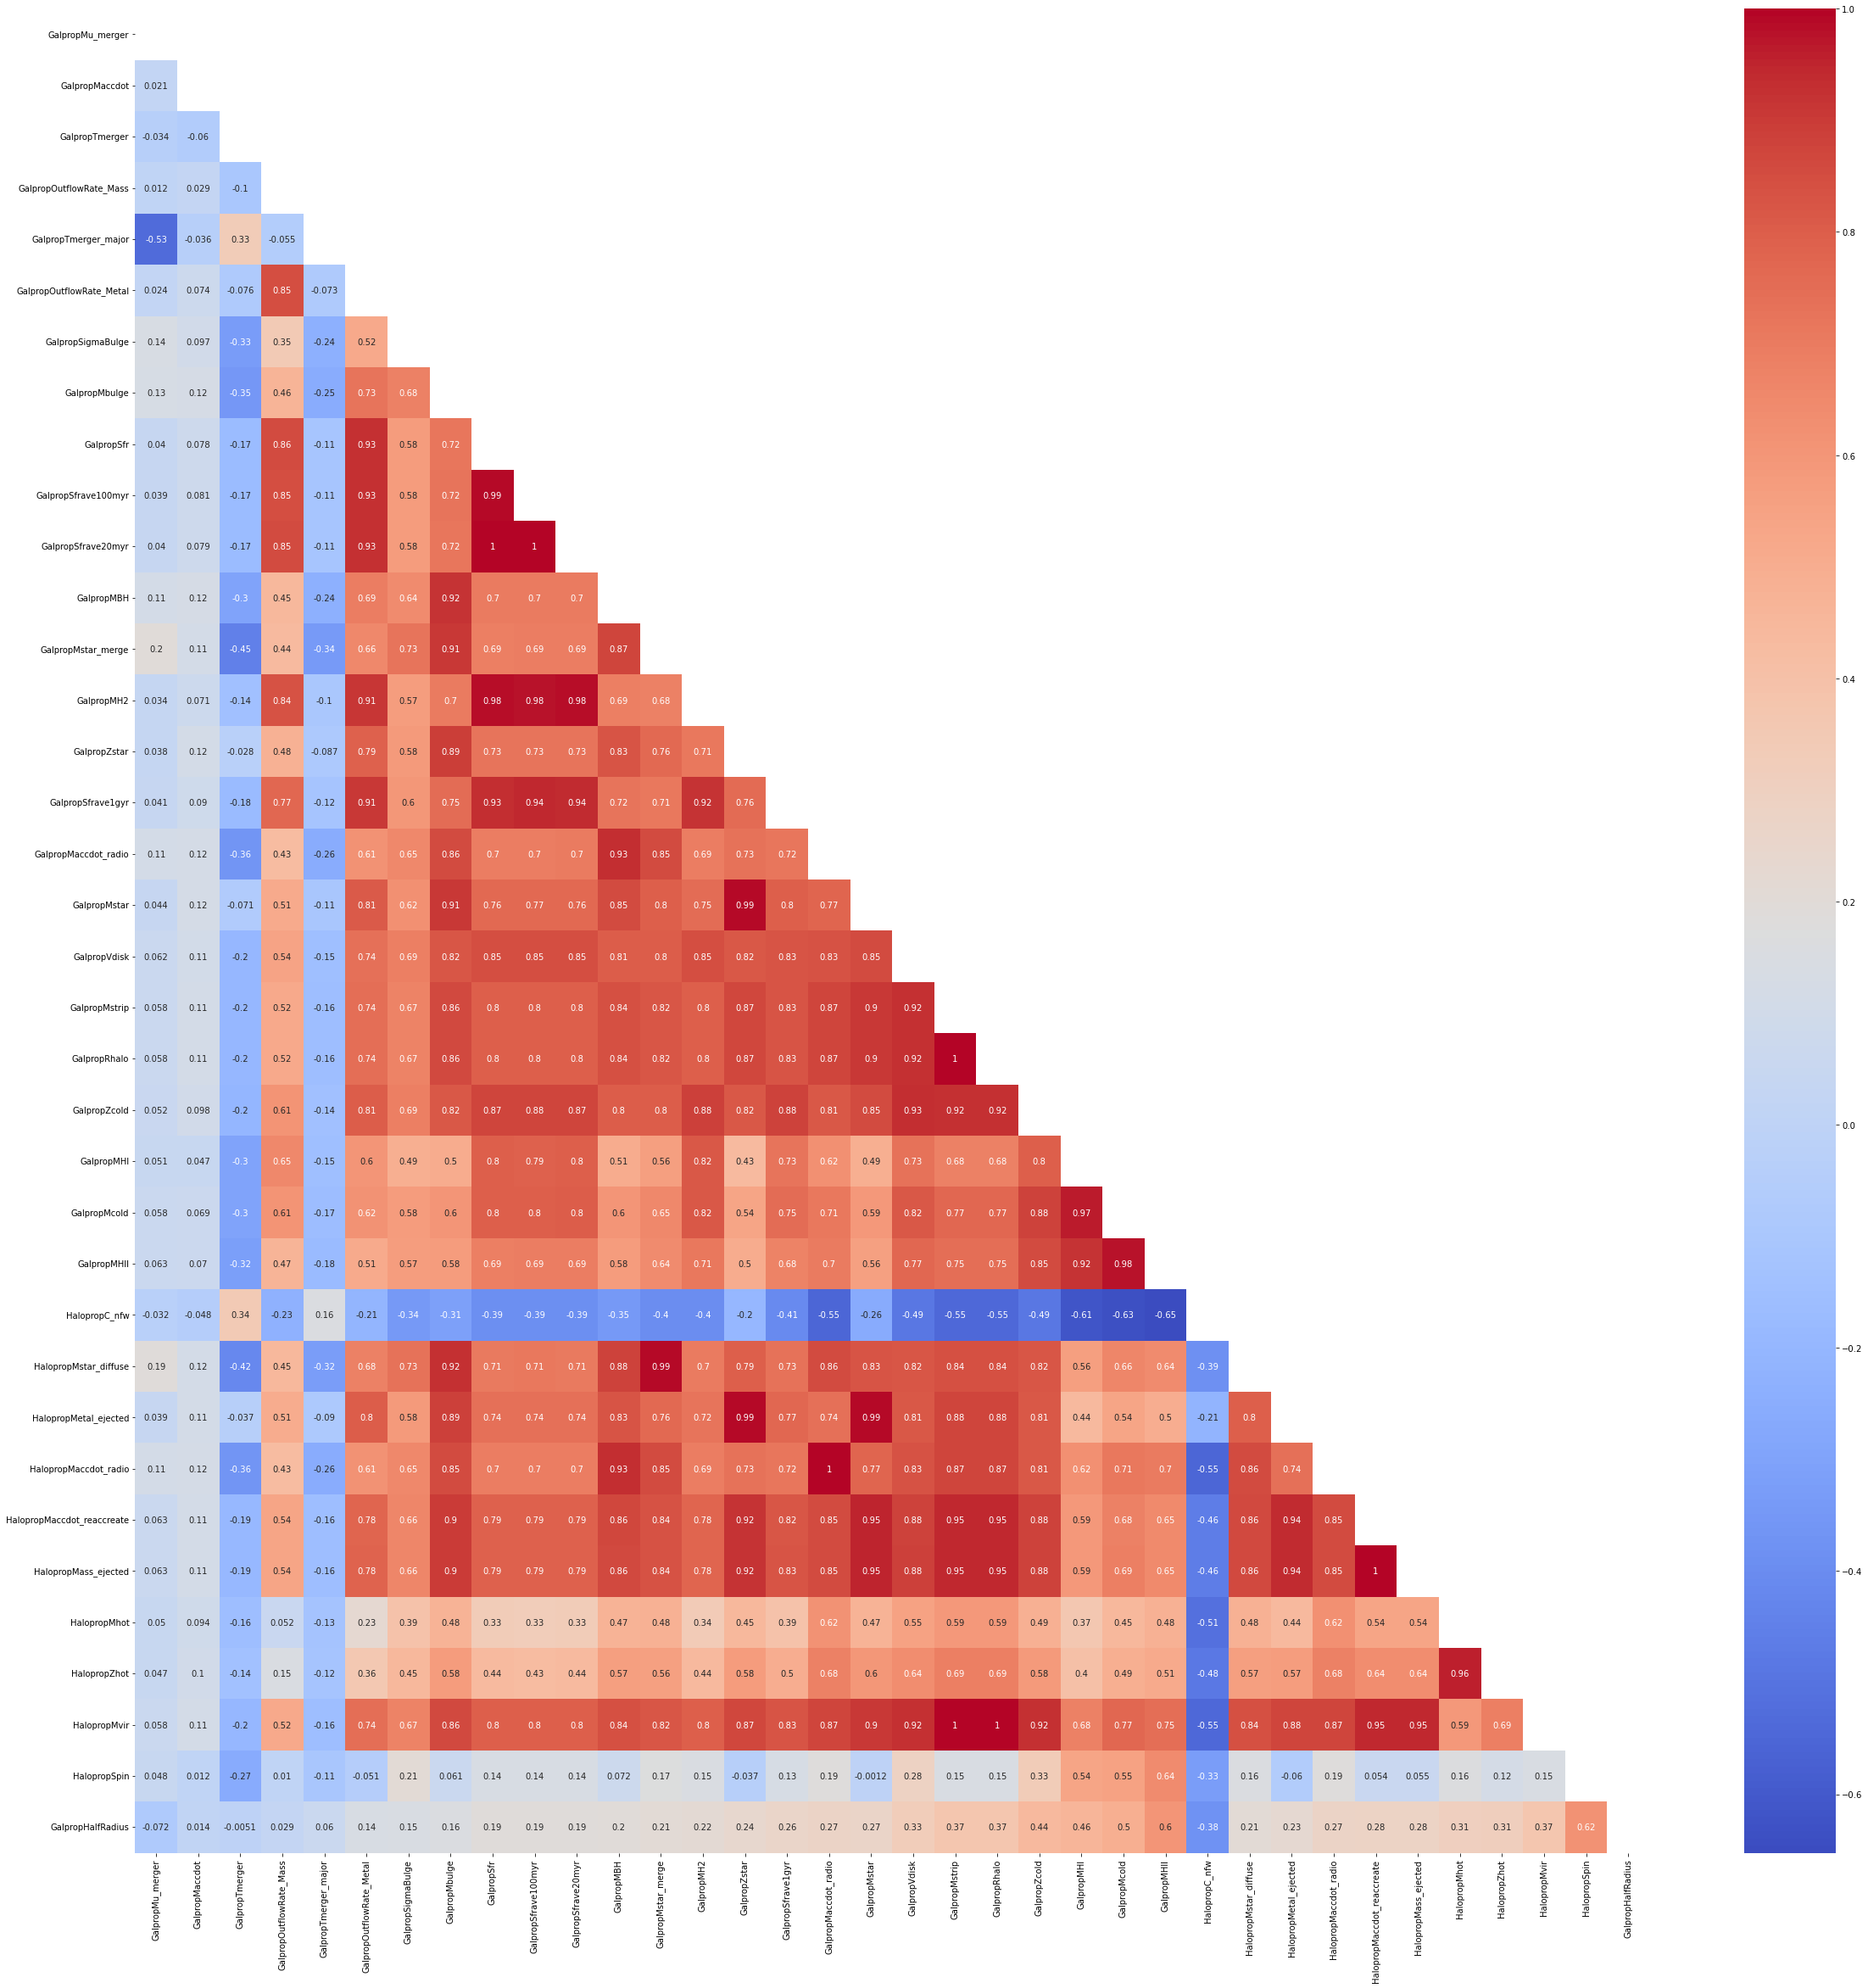

In [81]:
corr_df = df_pairplot.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
# plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
# plt.xlabel("Features", fontsize = 20)
# plt.savefig('TNG-SAM_morefeatures_Spearman_correlation_matrix_v3_wo_title.jpeg', dpi=500)
plt.show()

In [82]:
df_sample = df_pairplot.sample(n = 1000, random_state = 2022) #choose a subset of data to use for pairplot

In [83]:
df_sample.shape

(1000, 36)

### <font color='violet'> Size, Mass and Halo Spin plot



In [7]:
mass_size_corr = round(stats.spearmanr(df_log_mass_filtered['GalpropLogMstar'], 
                                               df_log_mass_filtered['GalpropLogHalfRadius'])[0], 2)
SFR_size_corr = round(stats.spearmanr(df_log_mass_filtered['GalpropLogSfr'], 
                                              df_log_mass_filtered['GalpropLogHalfRadius'] )[0], 2)
SFR_mass_corr = round(stats.spearmanr(df_log_mass_filtered['GalpropLogSfr'], 
                                              df_log_mass_filtered['GalpropLogMstar'] )[0], 2)
mom_size_corr = round(stats.spearmanr(df_log_mass_filtered['HalopropSpin'], 
                                              df_log_mass_filtered['GalpropLogHalfRadius'])[0], 2)


In [8]:
mass_size_corr

0.27

In [9]:
mom_size_corr

0.62

In [10]:
SFR_mass_corr

0.78

In [11]:
SFR_size_corr

0.2

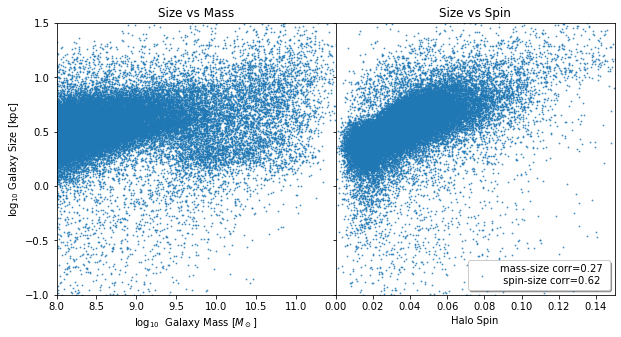

In [22]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_log_mass_filtered['GalpropLogMstar'], df_log_mass_filtered['GalpropLogHalfRadius'], 
                    s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-1.0,1.5])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df_log_mass_filtered['HalopropSpin'], df_log_mass_filtered['GalpropLogHalfRadius'], 
                     s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_centrals_Mass_Size_AngMom_v5_log.jpeg", dpi=500)
plt.show()